# Constrained Search tutorial
## Introduction
This is a tutorial describing how to locate the 40S small ribosomal subunit by using a constrained search from the 60S large subunit locations and orientations.

We will be using the mrc file xenon_131_000_0.0_DWS.mrc that can be found on Zenodo [https://zenodo.org/records/15628043](https://zenodo.org/records/15628043)

The micrograph looks like this:




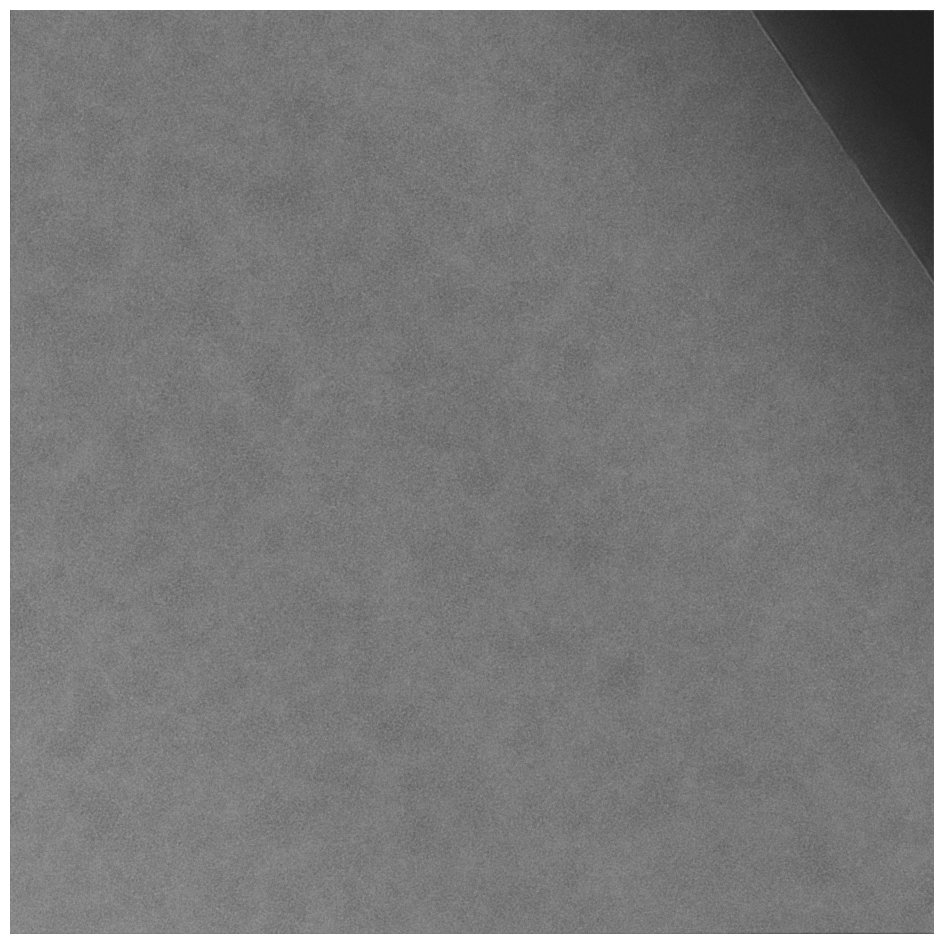

In [2]:
import matplotlib.pyplot as plt
import mrcfile
import numpy as np

# Open the MRC file
with mrcfile.open("mgraphs/xenon_131_000_0.0_DWS.mrc", permissive=True) as mrc:
    # Get the data
    data = mrc.data

    # If data is 3D, take the first slice
    if len(data.shape) > 2:
        data = data[0]

    # Create a figure with a larger size
    plt.figure(figsize=(12, 12))

    # Display the image
    plt.imshow(data, cmap="gray")

    # Remove axis ticks for cleaner visualization
    plt.axis("off")

    # Show the plot
    plt.show()

## Pre-process PDB files

### Download and edit files

We downloaded a PDB model of the 80S ribosome in the nonrotated state, 6Q8Y.
We visually inspected and generated two new PDB files of the 40S and 60S subunits.
For the 40S subunit, the head domain was also removed to leave only the body.
These models were aligned with respect to the 80S model using the matchmaker function in ChimeraX and saved in the models folder as the following: 6q8y_aligned.pdb, 60S_aligned.pdb, and 6q8y_SSU_no_head_aligned.pdb

### Centre PDB files
We are next going to centre the 80S PDB file at z,y,x 0,0,0.
This same shift will be applied to the 40S and 60S PDB so they are all still aligned.

In [5]:
import os

import mmdf
import torch


def center_and_align_pdbs(pdb_files):
    """
    Centers the first PDB file's coordinates at the origin.

    Applies the same shift to all other PDB files in the list.
    Saves all files with '_aligned_zero' suffix.

    Args:
        pdb_files: List of PDB file paths
    """
    if not pdb_files:
        print("No PDB files provided")
        return

    # Process the first PDB file
    first_pdb = pdb_files[0]
    print(f"Centering coordinates based on: {first_pdb}")

    # Read the first file using mmdf
    first_df = mmdf.read(first_pdb)

    # Extract coordinates from first file
    coords = torch.tensor(first_df[["z", "y", "x"]].to_numpy()).float()  # (n_atoms, 3)

    # Calculate center average
    center = torch.mean(coords, dim=0)
    print(f"Center: {center}")

    # Calculate the shift needed to center at origin
    shift_vector = -center

    # Process all PDB files with the same shift
    for pdb_file in pdb_files:
        # Generate output filename
        base_name = os.path.splitext(pdb_file)[0]
        output_file = f"{base_name}_aligned_zero.pdb"

        # Read the structure
        df = mmdf.read(pdb_file)

        # Apply shift to all coordinates
        coords = torch.tensor(df[["z", "y", "x"]].to_numpy()).float()  # (n_atoms, 3)
        coords += shift_vector  # Apply shift to all atoms

        # Update coordinates in dataframe
        df["z"] = coords[:, 0].numpy()
        df["y"] = coords[:, 1].numpy()
        df["x"] = coords[:, 2].numpy()

        # Write the modified structure
        mmdf.write(output_file, df)
        print(f"Saved: {output_file}")


# Using your specific file names
pdb_files = [
    "models/6q8y_aligned.pdb",
    "models/60S_aligned.pdb",
    "models/6q8y_SSU_no_head_aligned.pdb",
]
center_and_align_pdbs(pdb_files)

Centering coordinates based on: models/6q8y_aligned.pdb


/home/jdickerson/miniconda3/envs/leopard-em/lib/python3.12/site-packages/mmdf/_gemmi_utils.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Center: tensor([20.9556, 11.8620, 16.9626])


/home/jdickerson/miniconda3/envs/leopard-em/lib/python3.12/site-packages/mmdf/_gemmi_utils.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Saved: models/6q8y_aligned_aligned_zero.pdb
Saved: models/60S_aligned_aligned_zero.pdb
Saved: models/6q8y_SSU_no_head_aligned_aligned_zero.pdb


## Initial match template with 60S model
To perform a constrained search for the SSU, we first need to find the location and orientation of LSUs. 
### Simulate the map

The first thing we need to do is generate 3D maps from this model.
We're going to use the teamtomo package ttsim3d to do this.

The most important parameter is to make sure we set center atoms to false, otherwise the 60S will we cenntred at 0,0,0 and will no longer be aligned with the 40S

We have copied the mtf to this directory, and they can be found in ttsim3d repo under src/data/

In [1]:
from ttsim3d.models import Simulator, SimulatorConfig

# Instantiate the configuration object
sim_conf = SimulatorConfig(
    voltage=300.0,  # in keV
    apply_dose_weighting=True,
    dose_start=0.0,  # in e-/A^2
    dose_end=50.0,  # in e-/A^2
    dose_filter_modify_signal="rel_diff",
    upsampling=-1,  # auto
    mtf_reference="falcon4EC_300kv",
)

# Instantiate the simulator
sim = Simulator(
    pdb_filepath="models/60S_aligned_aligned_zero.pdb",
    pixel_spacing=0.95,  # Angstroms
    volume_shape=(512, 512, 512),
    center_atoms=False,
    remove_hydrogens=True,
    b_factor_scaling=0.5,
    additional_b_factor=0,
    simulator_config=sim_conf,
)

# Run the simulation
volume = sim.run()
print("Volume generated")

mrc_filepath = "maps/60S_map_px0.95_bscale0.5.mrc"
sim.export_to_mrc(mrc_filepath)

Volume generated


### Test match template run

We are now going to run match template on a small image patch. This will give us a few peaks that will allow us to optimize our template further.

The first thing we will do is crop our mrc file 4x in each dimension to be 1kx1k

In [2]:
import mrcfile


def crop_center(image, division_factor):
    """Crop the center of the image based on division factor."""
    h, w = image.shape
    new_h = h // division_factor
    new_w = w // division_factor

    # Calculate start indices for cropping
    start_h = h // 2 - new_h // 2
    start_w = w // 2 - new_w // 2

    return image[start_h : start_h + new_h, start_w : start_w + new_w]


def main():
    """Main function to crop the center of the image."""
    input_file = "mgraphs/xenon_131_000_0.0_DWS.mrc"
    division_factor = 4  # How much to crop by

    # Create output filename
    output_file = input_file.replace(".mrc", f"_cropped_{division_factor}.mrc")

    # Read input MRC
    with mrcfile.open(input_file, permissive=True) as mrc:
        data = mrc.data.copy()

        # Ensure the image is 2D
        if len(data.shape) > 2:
            print("Warning: Input has more than 2 dimensions. Using first slice.")
            data = data[0]

        # Crop the center
        cropped_data = crop_center(data, division_factor)

        # Write output MRC
        with mrcfile.new(output_file, overwrite=True) as mrc_new:
            mrc_new.set_data(cropped_data.astype(np.float32))
        print(f"Cropped image saved as {output_file}")


if __name__ == "__main__":
    main()

Cropped image saved as mgraphs/xenon_131_000_0.0_DWS_cropped_4.mrc


We will now set up a full match template run on this image.
We are using a default peak threshold of 1 false positive per image.

We will use a yaml file to make the inputs a little simpler than using pure python.
It's also a good idea to run any match_tm jobs in a screen or tmux session as it can be a long running operation.

In [3]:
# Add this to a code cell
from IPython.display import Markdown, display

# Read the YAML file
with open("configs/match_template_config_crop.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml

micrograph_path: mgraphs/xenon_131_000_0.0_DWS_cropped_4.mrc
template_volume_path: maps/60S_map_px0.95_bscale0.5.mrc
computational_config:
  gpu_ids:
  - 0
  - 1
  - 2
  - 3
  num_cpus: 8
defocus_search_config:
  enabled: true
  defocus_max: 1200.0
  defocus_min: -1200.0
  defocus_step: 200.0
match_template_result:
  allow_file_overwrite: true
  correlation_average_path: results/output_correlation_average.mrc
  correlation_variance_path: results/output_correlation_variance.mrc
  mip_path: results/output_mip.mrc
  orientation_phi_path: results/output_orientation_phi.mrc
  orientation_psi_path: results/output_orientation_psi.mrc
  orientation_theta_path: results/output_orientation_theta.mrc
  relative_defocus_path: results/output_relative_defocus.mrc
  scaled_mip_path: results/output_scaled_mip.mrc
optics_group:
  label: micrograph_1
  amplitude_contrast_ratio: 0.07
  ctf_B_factor: 60.0
  astigmatism_angle: 39.417260
  defocus_u: 5978.758301
  defocus_v: 5617.462402
  phase_shift: 0.0
  pixel_size: 0.95
  spherical_aberration: 2.7
  voltage: 300.0
orientation_search_config:
  base_grid_method: uniform
  psi_step: 1.5      # in degrees
  theta_step: 2.5  # in degrees
preprocessing_filters:
  bandpass_filter:
    enabled: false
    falloff: 0.05
    high_freq_cutoff: 0.5
    low_freq_cutoff: 0.0
  whitening_filter:
    enabled: true
    do_power_spectrum: true
    max_freq: 1.0
    num_freq_bins: null
```

In [ ]:
from leopard_em.pydantic_models.managers import MatchTemplateManager

YAML_CONFIG_PATH = "configs/match_template_config_crop.yaml"
ORIENTATION_BATCH_SIZE = 8


def main():
    """Main function to run the match template program."""
    mt_manager = MatchTemplateManager.from_yaml(YAML_CONFIG_PATH)
    mt_manager.run_match_template(ORIENTATION_BATCH_SIZE)
    df = mt_manager.results_to_dataframe(locate_peaks_kwargs={"false_positives": 1.0})
    df.to_csv("results/results_match_template_crop.csv")


# NOTE: invoking from `if __name__ == "__main__"` is necessary
# for proper multiprocessing/GPU-distribution behavior
if __name__ == "__main__":
    main()

Looking at the results.csv, we have 13 peaks above threshold. We will use this peaks for improving our simulated map.

## Map optimization
### Pixel size
The most important parameter to have accurate is the pixel size that we simulate the map with. This can be a few % incorrect, either because the pdb model was built into a map with the wrong pixel size and/or the microscope magnification was calibrated incorrectly. 

We will use another yaml file to run the pixel size optimizer.

In [8]:
from IPython.display import Markdown, display

# Read the YAML file
with open("configs/optimize_template_config.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml
#####################################################
### OptimizeTemplateManager configuration example ###
#####################################################
# An example YAML configuration to modify.
# Call `OptimizeTemplateManager.from_yaml(path)` to load this configuration.
particle_stack:
  df_path: results/results_match_template_crop.csv  # Needs to be readable by pandas
  extracted_box_size: [528, 528]
  original_template_size: [512, 512]
pixel_size_coarse_search:
  enabled: true
  pixel_size_min: -0.05
  pixel_size_max: 0.05
  pixel_size_step: 0.01
pixel_size_fine_search:
  enabled: true
  pixel_size_min: -0.008
  pixel_size_max: 0.008
  pixel_size_step: 0.001
preprocessing_filters:
  whitening_filter:
    do_power_spectrum: true
    enabled: true
    max_freq: 1.0  # In terms of Nyquist frequency
    num_freq_bins: null
  bandpass_filter:
    enabled: false
    falloff: null
    high_freq_cutoff: null
    low_freq_cutoff: null
computational_config:
  gpu_ids: 
    - 0
  num_cpus: 2
simulator:
  simulator_config:
    voltage: 300.0
    apply_dose_weighting: true
    dose_start: 0.0
    dose_end: 50.0
    dose_filter_modify_signal: "rel_diff"
    upsampling: -1  
    mtf_reference: "falcon4EC_300kv"
  pdb_filepath: "models/60S_aligned_aligned_zero.pdb"
  volume_shape: [512, 512, 512]
  b_factor_scaling: 0.5
  additional_b_factor: 0
  pixel_spacing: 0.95
  center_atoms: false
  remove_hydrogens: true


```

In [ ]:
from leopard_em.pydantic_models.managers import OptimizeTemplateManager

OPTIMIZE_YAML_PATH = "configs/optimize_template_config.yaml"


def main() -> None:
    """Main function to run the optimize template program."""
    otm = OptimizeTemplateManager.from_yaml(OPTIMIZE_YAML_PATH)
    otm.run_optimize_template(output_text_path="results/optimize_template_results.txt")


if __name__ == "__main__":
    main()

This gave us a pixel size of 0.936 that we can use from now on.

### Other parameters
The ctf B-factor is the next most important parameter to optimize. This can be done and is usually worthwhile. Since we don't need the best map for this tutorial, we will skip this for now and keep the ctf B as 60.

### Re-simulate maps
We will now resimulate both the LSU map and also simulate the SSU using the optimized pixel size.

In [2]:
from ttsim3d.models import Simulator, SimulatorConfig

# Instantiate the configuration object
sim_conf = SimulatorConfig(
    voltage=300.0,  # in keV
    apply_dose_weighting=True,
    dose_start=0.0,  # in e-/A^2
    dose_end=50.0,  # in e-/A^2
    dose_filter_modify_signal="rel_diff",
    upsampling=-1,  # auto
    mtf_reference="falcon4EC_300kv",
)

# Instantiate the simulator
sim = Simulator(
    pdb_filepath="models/60S_aligned_aligned_zero.pdb",
    pixel_spacing=0.936,  # Angstroms
    volume_shape=(512, 512, 512),
    center_atoms=False,
    remove_hydrogens=True,
    b_factor_scaling=0.5,
    additional_b_factor=0,
    simulator_config=sim_conf,
)

# Run the simulation
volume = sim.run()
print("Volume generated")

mrc_filepath = "maps/60S_map_px0.936_bscale0.5.mrc"
sim.export_to_mrc(mrc_filepath)

Volume generated


In [3]:
from ttsim3d.models import Simulator, SimulatorConfig

# Instantiate the configuration object
sim_conf = SimulatorConfig(
    voltage=300.0,  # in keV
    apply_dose_weighting=True,
    dose_start=0.0,  # in e-/A^2
    dose_end=50.0,  # in e-/A^2
    dose_filter_modify_signal="rel_diff",
    upsampling=-1,  # auto
    mtf_reference="falcon4EC_300kv",
)

# Instantiate the simulator
sim = Simulator(
    pdb_filepath="models/6q8y_SSU_no_head_aligned_aligned_zero.pdb",
    pixel_spacing=0.936,  # Angstroms
    volume_shape=(512, 512, 512),
    center_atoms=False,
    remove_hydrogens=True,
    b_factor_scaling=0.5,
    additional_b_factor=0,  # Add to all atoms
    simulator_config=sim_conf,
)

# Run the simulation
volume = sim.run()
print("Volume generated")

mrc_filepath = "maps/SSU-body_map_px0.936_bscale0.5.mrc"
sim.export_to_mrc(mrc_filepath)

Volume generated


## Match template
It's now time to do our full match template run using the 60S ribosome map.
We're going to use a similar yaml file to before, but with the full image and correct pixel size.
This will take under 3 hours on 4 A6000 GPUs. 

In [13]:
from IPython.display import Markdown, display

# Read the YAML file
with open("configs/match_template_config_60S.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml

micrograph_path: mgraphs/xenon_131_000_0.0_DWS.mrc
template_volume_path: maps/60S_map_px0.936_bscale0.5.mrc
computational_config:
  gpu_ids:
  - 0
  - 1
  - 2
  - 3
  num_cpus: 8
defocus_search_config:
  enabled: true
  defocus_max: 1200.0
  defocus_min: -1200.0
  defocus_step: 200.0
match_template_result:
  allow_file_overwrite: true
  correlation_average_path: results/output_correlation_average.mrc
  correlation_variance_path: results/output_correlation_variance.mrc
  mip_path: results/output_mip.mrc
  orientation_phi_path: results/output_orientation_phi.mrc
  orientation_psi_path: results/output_orientation_psi.mrc
  orientation_theta_path: results/output_orientation_theta.mrc
  relative_defocus_path: results/output_relative_defocus.mrc
  scaled_mip_path: results/output_scaled_mip.mrc
optics_group:
  label: micrograph_1
  amplitude_contrast_ratio: 0.07
  ctf_B_factor: 60.0
  astigmatism_angle: 39.417260
  defocus_u: 5978.758301
  defocus_v: 5617.462402
  phase_shift: 0.0
  pixel_size: 0.936
  spherical_aberration: 2.7
  voltage: 300.0
orientation_search_config:
  base_grid_method: uniform
  psi_step: 1.5      # in degrees
  theta_step: 2.5  # in degrees
preprocessing_filters:
  bandpass_filter:
    enabled: false
    falloff: 0.05
    high_freq_cutoff: 0.5
    low_freq_cutoff: 0.0
  whitening_filter:
    enabled: true
    do_power_spectrum: true
    max_freq: 1.0
    num_freq_bins: null
```

In [ ]:
YAML_CONFIG_PATH = "configs/match_template_config_60S.yaml"
ORIENTATION_BATCH_SIZE = 8


def main():
    """Main function to run the match template program."""
    mt_manager = MatchTemplateManager.from_yaml(YAML_CONFIG_PATH)
    mt_manager.run_match_template(ORIENTATION_BATCH_SIZE)
    df = mt_manager.results_to_dataframe(locate_peaks_kwargs={"false_positives": 1.0})
    df.to_csv("results/results_match_template_60S.csv")


# NOTE: invoking from `if __name__ == "__main__"` is necessary
# for proper multiprocessing/GPU-distribution behavior
if __name__ == "__main__":
    main()

We have found 415 peaks above threshold.

However, with this micrograph, we must be careful since the edge of the lamella in the top right of the image can cause false correlations. This is because although the MIP is below threshold, the low variance in these dark patches push the z-score above our threshold.

The recommended strategy is to replace this part of the image with random noise with the same mean and standard deviation of the rest of the image.

For the purpose of this tutorial, we simply impose that both the MIP and scaled MIP must both be above the threshold for call a peak. This will remove these false positives at the cost of increasing false negatives.





In [3]:
import pandas as pd
from scipy.special import erfcinv


def gaussian_noise_zscore_cutoff(num_ccg: int, false_positives: float = 1.0) -> float:
    """
    Calculate the cutoff value for the gaussian noise z-score.

    Parameters
    ----------
    num_ccg: int
        The number of correlations in the micrograph.
    false_positives: float
        The false positive rate.

    Returns
    -------
    float
        The cutoff value for the gaussian noise z-score.
    """
    tmp = erfcinv(2.0 * false_positives / num_ccg)
    tmp *= np.sqrt(2.0)
    return float(tmp)


def main():
    """Main function to filter the results from the match template."""
    # Read the CSV file
    df = pd.read_csv("results/results_match_template_60S.csv")

    # Calculate the cutoff value
    # Using the total_correlations from the first row since it's the same for all rows
    num_ccg = df["total_correlations"].iloc[0] * (4096 - 512 + 1) ** 2
    cutoff = gaussian_noise_zscore_cutoff(num_ccg, false_positives=1.0)

    print(f"Cutoff value: {cutoff}")

    # Filter rows where either mip or scaled_mip is above the cutoff
    filtered_df = df[(df["mip"] > cutoff) & (df["scaled_mip"] > cutoff)]

    # Save the filtered results
    filtered_df.to_csv("results/results_match_template_60S_edit.csv", index=False)

    print(f"Original number of particles: {len(df)}")
    print(f"Number of particles after filtering: {len(filtered_df)}")


if __name__ == "__main__":
    main()

Cutoff value: 7.77483174236834
Original number of particles: 415
Number of particles after filtering: 405


This filters out 10 particles, no we are now at 405

## Refine template
We're now going to run a refine template on the particles. We are not using this to find new particles, but simply improve our estimates of the location and orientation of each particle we have already found. The main difference between match template and refine template is match template runs on the entire micrograph, whereas refine template searches over a particle stack on already oriented particles.

We're again using a yaml file. The extracted box size is 6x6 bigger than the template (it must be even). This means we only consider the middle 6x6 of each peak. This does not allow the peak to move much, but this is fine for the 60S. 

In [5]:
from IPython.display import Markdown, display

# Read the YAML file
with open("configs/refine_template_config_60S.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml
###################################################
### RefineTemplateManager configuration example ###
###################################################
# An example YAML configuration to modify.
# Call `RefineTemplateManager.from_yaml(path)` to load this configuration.
template_volume_path: maps/60S_map_px0.936_bscale0.5.mrc
particle_stack:
  df_path: results/results_match_template_60S_edit.csv  # Needs to be readable by pandas
  extracted_box_size: [518, 518]
  original_template_size: [512, 512]
defocus_refinement_config:
  enabled: true
  defocus_max:  100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_min: -100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_step: 20.0   # in Angstroms
orientation_refinement_config:
  enabled: true
  psi_step_coarse:     1.5   # in degrees
  psi_step_fine:       0.05  # in degrees
  theta_step_coarse:   2.5   # in degrees
  theta_step_fine:     0.05  # in degrees
pixel_size_refinement_config:
  enabled: false
  pixel_size_min: -0.005
  pixel_size_max: 0.005
  pixel_size_step: 0.001
preprocessing_filters:
  whitening_filter:
    do_power_spectrum: true
    enabled: true
    max_freq: 1.0  # In terms of Nyquist frequency
    num_freq_bins: null
  bandpass_filter:
    enabled: false
    falloff: null
    high_freq_cutoff: null
    low_freq_cutoff: null
computational_config:
  gpu_ids: 
  - 0
  - 1
  - 2
  - 3
  num_cpus: 8
```

In [ ]:
import time

from leopard_em.pydantic_models.managers import RefineTemplateManager

#######################################
### Editable parameters for program ###
#######################################

# Edit your YAML file to configure the refine template program.
# Needs to reference the outputs from a match template run.
# See online documentation for more information on editing this file.
YAML_CONFIG_PATH = "configs/refine_template_config_60S.yaml"

# Path to where the dataframe with refined peak parameters will be output.
DATAFRAME_OUTPUT_PATH = "results/results_refine_template_60S.csv"

# Number of particles to refine simultaneously. Will need to tune this parameter
# based on the memory & computational resources available.
PARTICLE_BATCH_SIZE = 64

###############################################################
### Main function called to run the refine template program ###
###############################################################


def main() -> None:
    """Main function for running the refine template program."""
    rt_manager = RefineTemplateManager.from_yaml(YAML_CONFIG_PATH)

    print("Loaded configuration.")
    print("Running refine template...")

    start_time = time.time()

    rt_manager.run_refine_template(DATAFRAME_OUTPUT_PATH, PARTICLE_BATCH_SIZE)

    print("Finished core refine_template call.")

    # Print the wall time of the search in HH:MM:SS
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    print(f"Refine template wall time: {elapsed_time_str}")

    print("Done!")


# NOTE: Invoking  program under `if __name__ == "__main__"` necessary for multiprocesing
if __name__ == "__main__":
    main()

We could continue to refien the angles and defocus further by using this refine_results.csv as the input for another. However, we are happt with these angles for now.

## Searching for the 40S

The 40S is smaller and more flexible than the 60S, which makes it harder to search for.
Nonetheless, we will first do a full match template and look at the results. This is also necessary for the constrained search, since the mean and standard deviation from this search is used for to normalize the constrained search.
We will look for the SSU body only, since this is a rigid part and should therefore give us more overall counts that using the whole thing.

In [3]:
from IPython.display import Markdown, display

# Read the YAML file
with open("configs/match_template_config_40S.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml

micrograph_path: mgraphs/xenon_131_000_0.0_DWS.mrc
template_volume_path: maps/SSU-body_map_px0.936_bscale0.5.mrc
computational_config:
  gpu_ids:
  - 0
  - 1
  - 2
  - 3
  num_cpus: 8
defocus_search_config:
  enabled: true
  defocus_max: 1200.0
  defocus_min: -1200.0
  defocus_step: 200.0
match_template_result:
  allow_file_overwrite: true
  correlation_average_path: results/output_correlation_average_40S.mrc
  correlation_variance_path: results/output_correlation_variance_40S.mrc
  mip_path: results/output_mip_40S.mrc
  orientation_phi_path: results/output_orientation_phi_40S.mrc
  orientation_psi_path: results/output_orientation_psi_40S.mrc
  orientation_theta_path: results/output_orientation_theta_40S.mrc
  relative_defocus_path: results/output_relative_defocus_40S.mrc
  scaled_mip_path: results/output_scaled_mip_40S.mrc
optics_group:
  label: micrograph_1
  amplitude_contrast_ratio: 0.07
  ctf_B_factor: 60.0
  astigmatism_angle: 39.417260
  defocus_u: 5978.758301
  defocus_v: 5617.462402
  phase_shift: 0.0
  pixel_size: 0.936
  spherical_aberration: 2.7
  voltage: 300.0
orientation_search_config:
  base_grid_method: uniform
  psi_step: 1.5      # in degrees
  theta_step: 2.5  # in degrees
preprocessing_filters:
  bandpass_filter:
    enabled: false
    falloff: 0.05
    high_freq_cutoff: 0.5
    low_freq_cutoff: 0.0
  whitening_filter:
    enabled: true
    do_power_spectrum: true
    max_freq: 1.0
    num_freq_bins: null
```

In [ ]:
YAML_CONFIG_PATH = "configs/match_template_config_40S.yaml"
ORIENTATION_BATCH_SIZE = 8


def main():
    """Main function to run the match template program."""
    mt_manager = MatchTemplateManager.from_yaml(YAML_CONFIG_PATH)
    mt_manager.run_match_template(ORIENTATION_BATCH_SIZE)
    df = mt_manager.results_to_dataframe(locate_peaks_kwargs={"false_positives": 1.0})
    df.to_csv("results/results_match_template_40S.csv")


# NOTE: invoking from `if __name__ == "__main__"` is necessary
# for proper multiprocessing/GPU-distribution behavior
if __name__ == "__main__":
    main()

We have 236 peaks, but lots of these are in the corner of the micrograph where the edge of the lamella is. We will apply the same filtering.

In [4]:
def main():
    """Main function to filter the results from the match template."""
    # Read the CSV file
    df = pd.read_csv("results/results_match_template_40S.csv")

    # Calculate the cutoff value
    # Using the total_correlations from the first row since it's the same for all rows
    num_ccg = df["total_correlations"].iloc[0] * (4096 - 512 + 1) ** 2
    cutoff = gaussian_noise_zscore_cutoff(num_ccg, false_positives=1.0)

    print(f"Cutoff value: {cutoff}")

    # Filter rows where either mip or scaled_mip is above the cutoff
    filtered_df = df[(df["mip"] > cutoff) & (df["scaled_mip"] > cutoff)]

    # Save the filtered results
    filtered_df.to_csv("results/results_match_template_40S_edit.csv", index=False)

    print(f"Original number of particles: {len(df)}")
    print(f"Number of particles after filtering: {len(filtered_df)}")


if __name__ == "__main__":
    main()

Cutoff value: 7.77483174236834
Original number of particles: 236
Number of particles after filtering: 13


We could now combine the results form the 60S and 40S searches to classify 80S ribosomes based on 40S rotation angle. However, a better strategy would be to use a constrained search to search for the 40S based on the positions and orientations of the 60S. By restricting the location and orientation space, we lower our threshold so increase our sensitivity.

### Constrained search

The 40S subunit has many degrees of freedom. It can rotate relative to the 60S and also within the 40S there is head and body domain that can 'swivel' with respect to one another.
For the purpose of this tutorial, we will ignore the latter and consider the 40S as one rigid body moving with respect to the 60S.

The first thing we need to do is find out the axis of rotation.
To do this, we will use two PDB models, 3j77 and 3j78, that are different rotational states.

We then used the mathmaker function in ChimeraX to align these relative to the 60S model we used for template matching.  We selected only the proteins in the 40S subunit in each model and saved these as 3j77/8_SSU_aligned_zero.pdb.

We then ran the following script, which is also present in leopard-em/programs/constrained_search/utils/get_rot_axis.py.
This script determines the rotation axis between two PDB models.
It then calculates the rotation matrix needed to align this axis with the 'Z' axis.
Finally, it outputs the euler angles necessary to align these, which are used as inputs for the constrained search.




In [2]:
import math
import sys

import roma

sys.argv = [
    "get_rot_axis.py",
    "models/3j77_SSU_aligned_zero.pdb",
    "models/3j78_SSU_aligned_zero.pdb",
    "results/rotation_axis.txt",
]


def extract_rotation_axis_angle(rotmat: torch.Tensor) -> tuple[torch.Tensor, float]:
    """Extract rotation axis and angle from rotation matrix.

    Attributes
    ----------
    rotmat: torch.Tensor
        The rotation matrix.

    Returns
    -------
    tuple[torch.Tensor, float]
        The rotation axis and angle.
    """
    # Calculate angle from trace
    trace = torch.trace(rotmat)
    cos_theta = (trace - 1) / 2
    cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
    angle = torch.acos(cos_theta)

    # Handle special cases (very small angles or near 180 degrees)
    if torch.abs(angle) < 1e-6:
        return torch.tensor([0.0, 0.0, 1.0]), angle
    elif torch.abs(angle - math.pi) < 1e-6:
        diag = torch.diag(rotmat) + 1
        axis_idx = torch.argmax(diag)
        axis = rotmat[:, axis_idx].clone()
        axis = axis / torch.norm(axis)
        # Ensure the axis points in the positive z direction
        if axis[2] < 0:
            axis = -axis
        return axis, angle

    # Normal case - extract axis
    axis = torch.tensor(
        [
            rotmat[2, 1] - rotmat[1, 2],
            rotmat[0, 2] - rotmat[2, 0],
            rotmat[1, 0] - rotmat[0, 1],
        ]
    )

    # Normalize the axis
    axis = axis / torch.norm(axis)

    # Ensure the axis points in the positive z direction
    if axis[2] < 0:
        axis = -axis
        angle = -angle  # Also flip the angle when we flip the axis
        angle = angle + 2 * math.pi if angle < 0 else angle  # Keep angle positive

    return axis, angle


def calculate_axis_euler_angles(axis: torch.Tensor) -> tuple[float, float]:
    """Calculate Euler angles (ZYZ) that for the rotation axis.

    Attributes
    ----------
    axis: torch.Tensor
        The rotation axis.

    Returns
    -------
    tuple[float, float]
        The Euler angles.
    """
    # Z-axis unit vector
    z_axis = torch.tensor([0.0, 0.0, 1.0], dtype=torch.float32)

    # Handle special cases
    if torch.norm(axis - z_axis) < 1e-6:
        return 0.0, 0.0  # Axis aligned with z-axis

    if torch.norm(axis + z_axis) < 1e-6:
        return 0.0, 180.0  # Axis anti-aligned with z-axis

    # Calculate theta - angle from z-axis (polar angle)
    cos_theta = torch.dot(axis, z_axis)
    theta = torch.acos(torch.clamp(cos_theta, -1.0, 1.0)) * 180 / math.pi

    # Calculate phi - angle in xy plane (azimuthal angle)
    phi = torch.atan2(axis[1], axis[0]) * 180 / math.pi
    if phi < 0:
        phi += 360.0  # Convert to 0-360 range

    return phi, theta


def main() -> None:
    """Calculate rotation axis for a pair of PDB structures."""
    if len(sys.argv) != 4:
        print(f"Usage: {sys.argv[0]} <pdb_file1> <pdb_file2> <output_file>")
        sys.exit(1)

    pdb_file1 = sys.argv[1]
    pdb_file2 = sys.argv[2]
    output_file = sys.argv[3]

    # Parse PDB files
    df1 = mmdf.read(pdb_file1)
    df2 = mmdf.read(pdb_file2)

    # Extract coordinates
    coords1 = torch.tensor(df1[["x", "y", "z"]].values, dtype=torch.float32)
    coords2 = torch.tensor(df2[["x", "y", "z"]].values, dtype=torch.float32)

    # Center coordinates
    centroid1 = coords1.mean(dim=0)
    centroid2 = coords2.mean(dim=0)
    coords1_centered = coords1 - centroid1
    coords2_centered = coords2 - centroid2

    # Calculate rotation matrix
    # rotation_matrix = calculate_rotation_matrix(coords1_centered, coords2_centered)
    rotation_matrix, _ = roma.rigid_points_registration(
        coords1_centered, coords2_centered
    )
    # Extract rotation axis and angle
    rotation_axis, rotation_angle = extract_rotation_axis_angle(rotation_matrix)

    # Calculate Euler angles for the rotation axis
    phi, theta = calculate_axis_euler_angles(rotation_axis)

    # Output results
    angle_degrees = float(rotation_angle) * 180 / math.pi

    print("\nRotation Analysis Results:")
    print(
        f"Rotation Axis: [{rotation_axis[0]:.6f}, "
        f"{rotation_axis[1]:.6f}, {rotation_axis[2]:.6f}]"
    )
    print(f"Rotation Angle: {angle_degrees:.2f} degrees")

    print("\nEuler Angles of the rotation axis (ZYZ convention):")
    print(f"  Phi:   {phi:.2f} degrees (range 0-360)")
    print(f"  Theta: {theta:.2f} degrees (range 0-180)")

    # Write results to output file
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("# PDB Rotation Analysis Results\n\n")
        f.write(f"Source PDB: {pdb_file1}\n")
        f.write(f"Target PDB: {pdb_file2}\n")
        f.write(f"Number of atoms: {len(df1)}\n\n")

        f.write("## Rotation Parameters\n")
        f.write(
            f"Axis: {rotation_axis[0]:.6f} "
            f"{rotation_axis[1]:.6f} {rotation_axis[2]:.6f}\n"
        )
        f.write(f"Angle: {angle_degrees:.6f} degrees\n\n")

        f.write("## Axis Orientation Angles (for constrained search config)\n")
        f.write(f"rotation_axis_euler_angles: [{phi:.2f}, {theta:.2f}, 0.0]\n\n")

        f.write("## Example constrained search config\n")
        f.write("orientation_refinement_config:\n")
        f.write("  enabled: true\n")
        f.write("  out_of_plane_step: 1.0   # Step size around the rotation axis\n")
        f.write("  in_plane_step: 0.5       # Step size for fine adjustment angles\n")
        f.write(f"  rotation_axis_euler_angles: [{phi:.2f}, {theta:.2f}, 0.0]\n")
        suggested_range = min(30.0, max(10.0, angle_degrees / 2))
        f.write(
            f"  phi_min: -{suggested_range:.1f}  # Search range for around the axis\n"
        )
        f.write(f"  phi_max: {suggested_range:.1f}\n")
        f.write(
            "  theta_min: -2.0  # Small adjustments perpendicular to axis (optional)\n"
        )
        f.write("  theta_max: 2.0\n")
        f.write("  psi_min: -2.0    # Small in-plane adjustments (optional)\n")
        f.write("  psi_max: 2.0\n")

    print(f"Rotation analysis written to: {output_file}")
    print("\nFor your constrained search config.yaml:")
    print(f"rotation_axis_euler_angles: [{phi:.2f}, {theta:.2f}, 0.0]")


if __name__ == "__main__":
    main()


Rotation Analysis Results:
Rotation Axis: [0.206551, 0.841233, 0.499663]
Rotation Angle: 348.73 degrees

Euler Angles of the rotation axis (ZYZ convention):
  Phi:   76.20 degrees (range 0-360)
  Theta: 60.02 degrees (range 0-180)
Rotation analysis written to: results/rotation_axis.txt

For your constrained search config.yaml:
rotation_axis_euler_angles: [76.20, 60.02, 0.0]


This tells us the rotation matrix that we apply to align the rotation axis with the Z axis. This makes it very simple to search over just the phi/psi range.

As well as constrainig the angles. We can also don't need to do the defocus search. The program uses the defocus and orientation of the 60S to work out the height of the 40S. For this, it needs to know the offset between the two subunits in the default orientation. We have a helper script for this.


In [3]:
import argparse

import torch

sys.argv = [
    "get_centre_vector.py",
    "models/60S_aligned_aligned_zero.pdb",
    "models/6q8y_SSU_no_head_aligned_aligned_zero.pdb",
    "--num-rotations",
    "5",
    "--output-file",
    "results/output_centre_vector.txt",
]


def calculate_mean_position(df: pd.DataFrame) -> torch.Tensor:
    """
    Calculate the mean position of a PDB structure.

    Attributes
    ----------
    df: pd.DataFrame
        The mmdf DataFrame with the PDB structure.

    Returns
    -------
    torch.Tensor
        The mean position as a 3D vector [x, y, z].
    """
    # Extract coordinates and calculate mean
    coords = torch.tensor(df[["x", "y", "z"]].values, dtype=torch.float32)
    mean_pos = coords.mean(dim=0)

    return mean_pos


def rotate_vector(vector: torch.Tensor, rotation_matrix: torch.Tensor) -> torch.Tensor:
    """
    Rotate a vector using a rotation matrix.

    Attributes
    ----------
    vector: torch.Tensor
        The vector to rotate.
    rotation_matrix: torch.Tensor
        The rotation matrix to use.

    Returns
    -------
        Rotated vector
    """
    # Convert to tensor if not already
    if not isinstance(vector, torch.Tensor):
        vector = torch.tensor(vector, dtype=torch.float32)

        # Ensure matching types between rotation_matrix and vector
    if rotation_matrix.dtype != vector.dtype:
        rotation_matrix = rotation_matrix.to(dtype=vector.dtype)

    # Apply rotation
    rotated_vector = rotation_matrix @ vector

    return rotated_vector


def setup_argparse() -> argparse.Namespace:
    """
    Set up and parse command line arguments.

    Returns
    -------
    argparse.Namespace
        Parsed command line arguments
    """
    parser = argparse.ArgumentParser(
        description="Calculate vector between PDB structures"
    )
    parser.add_argument("pdb_file1", help="PDB file of larger structure")
    parser.add_argument("pdb_file2", help="PDB file of smaller structure")
    parser.add_argument(
        "--num-rotations",
        type=int,
        default=5,
        help="Number of random rotations to test",
    )
    parser.add_argument(
        "--output-file", default="defocus_analysis.txt", help="Output analysis file"
    )
    return parser.parse_args()


def calculate_relative_vectors(pdb_file1: str, pdb_file2: str) -> dict:
    """
    Calculate the relative position and orientation vectors between two PDB structures.

    Parameters
    ----------
    pdb_file1 : str
        Path to the first PDB file
    pdb_file2 : str
        Path to the second PDB file

    Returns
    -------
    dict
        Dictionary containing relative vector data including:
        - df1, df2: DataFrames for both PDB files
        - vector: Vector from PDB1 to PDB2
        - euler_angles: Phi, Theta, Psi angles
        - z_diff: Z height difference
        - defocus_description: Human-readable defocus description
    """
    # Parse PDB files using mmdf
    df1 = mmdf.read(pdb_file1)
    df2 = mmdf.read(pdb_file2)

    print(f"File 1: {pdb_file1} - {len(df1)} atoms")
    print(f"File 2: {pdb_file2} - {len(df2)} atoms")

    # Calculate mean positions at default orientation (0,0,0)
    mean_pos1 = calculate_mean_position(df1)
    mean_pos2 = calculate_mean_position(df2)

    # Calculate vector from PDB1 to PDB2
    vector = mean_pos2 - mean_pos1

    # Convert vector to Euler angles
    phi, theta, psi = roma.rotvec_to_euler(
        convention="ZYZ", rotvec=vector, degrees=True, as_tuple=True
    )

    # Calculate Z-height difference (defocus)
    z_diff = vector[2].item()
    defocus_description = (
        f"{abs(z_diff):.2f} Angstroms {'below' if z_diff < 0 else 'above'}"
    )

    # Print initial results
    print("\nInitial Analysis:")
    print(
        f"Vector from PDB1 to PDB2: [{vector[0]:.6f}, {vector[1]:.6f}, {vector[2]:.6f}]"
    )
    print(
        f"Vector Euler angles (ZYZ): Phi={phi:.2f}°, Theta={theta:.2f}°, Psi={psi:.2f}°"
    )
    print(f"Z-height difference (defocus): {defocus_description}")

    return {
        "df1": df1,
        "df2": df2,
        "vector": vector,
        "euler_angles": (phi, theta, psi),
        "z_diff": z_diff,
        "defocus_description": defocus_description,
    }


def generate_rotation_samples(num_rotations: int) -> torch.Tensor:
    """
    Generate a set of random rotations for testing.

    Parameters
    ----------
    num_rotations : int
        Number of random rotations to generate

    Returns
    -------
    torch.Tensor
        Tensor containing rotation angles (Euler ZYZ convention)
    """
    # Generate random Euler angles for testing
    if num_rotations > 1:
        # Generate all random angles with a single call
        random_rotations = np.random.uniform(-180, 180, size=(num_rotations - 1, 3))
        # Adjust theta values to be between 0 and 180
        random_rotations[:, 1] = np.abs(random_rotations[:, 1]) % 180
        # Start with default orientation [0,0,0] and concatenate random rotations
        rotations = np.vstack(([0.0, 0.0, 0.0], random_rotations))
    else:
        # Just use the default orientation if num_rotations is 1
        rotations = np.array([[0.0, 0.0, 0.0]])

    # Convert to tensor for batch processing
    return torch.tensor(rotations, dtype=torch.float32)


def process_rotations(vector: torch.Tensor, rotations_tensor: torch.Tensor) -> list:
    """
    Process each rotation and calculate the resulting defocus.

    Parameters
    ----------
    vector : torch.Tensor
        The original vector between structures
    rotations_tensor : torch.Tensor
        Tensor containing rotation angles to test

    Returns
    -------
    list
        List of dictionaries with defocus results for each rotation
    """
    print("\nDefocus changes for different rotations:")
    defocus_results = []

    for i, euler in enumerate(rotations_tensor):
        # Convert degrees to radians using np.deg2rad
        phi_rad, theta_rad, psi_rad = (np.deg2rad(angle.item()) for angle in euler)

        # Create rotation matrix using RoMA (ZYZ intrinsic convention)
        euler_angles = torch.tensor([phi_rad, theta_rad, psi_rad])
        rotation_matrix = roma.rotvec_to_rotmat(
            roma.euler_to_rotvec(convention="ZYZ", angles=euler_angles)
        )

        # Rotate the vector
        rotated_vector = rotate_vector(vector, rotation_matrix)

        # Extract new z-component (defocus)
        new_z_diff = rotated_vector[2].item()
        new_defocus = (
            f"{abs(new_z_diff):.2f} Angstroms {'below' if new_z_diff < 0 else 'above'}"
        )

        print(
            f"Rotation #{i+1} - Euler({euler[0]:.2f}°, {euler[1]:.2f}°, "
            f"{euler[2]:.2f}°): Defocus = {new_defocus}"
        )

        defocus_results.append(
            {
                "rotation": i + 1,
                "euler_angles": [e.item() for e in euler],
                "defocus": new_z_diff,
                "description": new_defocus,
            }
        )

    return defocus_results


def write_results_to_file(
    output_file: str,
    pdb_file1: str,
    pdb_file2: str,
    vector_data: dict,
    defocus_results: list,
) -> None:
    """
    Write analysis results to output file.

    Parameters
    ----------
    output_file : str
        Path to output file
    pdb_file1 : str
        Path to first PDB file
    pdb_file2 : str
        Path to second PDB file
    vector_data : dict
        Dictionary with vector data from calculate_relative_vectors
    defocus_results : list
        List of defocus results from process_rotations
    """
    vector = vector_data["vector"]
    phi, theta, psi = vector_data["euler_angles"]
    defocus_description = vector_data["defocus_description"]

    with open(output_file, "w") as f:
        f.write("# PDB Vector and Defocus Analysis\n\n")
        f.write(f"Source PDB 1: {pdb_file1}\n")
        f.write(f"Source PDB 2: {pdb_file2}\n\n")

        f.write("## Initial Vector Analysis\n")
        f.write(
            f"Vector PDB1-PDB2: [{vector[0]:.6f}, {vector[1]:.6f}, {vector[2]:.6f}]\n"
        )
        f.write(
            f"Vector Eulers (ZYZ): Phi={phi:.2f}°, Theta={theta:.2f}°, Psi={psi:.2f}°\n"
        )
        f.write(f"Z-height difference (defocus): {defocus_description}\n\n")

        f.write("## Defocus changes for different rotations\n")
        for result in defocus_results:
            euler = result["euler_angles"]
            f.write(
                f"Rotation #{result['rotation']} - "
                f"Euler({euler[0]:.2f}°, {euler[1]:.2f}°, {euler[2]:.2f}°): "
            )
            f.write(f"Defocus = {result['description']}\n")

    print(f"\nAnalysis results written to {output_file}")


def main() -> None:
    """Main function to calculate the center vector between two PDB structures."""
    # Setup argparse
    args = setup_argparse()

    # Calculate relative position and orientation vectors
    vector_data = calculate_relative_vectors(args.pdb_file1, args.pdb_file2)

    # Generate random rotation samples
    rotations_tensor = generate_rotation_samples(args.num_rotations)

    # Process each rotation and collect results
    defocus_results = process_rotations(vector_data["vector"], rotations_tensor)

    # Write results to file
    write_results_to_file(
        args.output_file, args.pdb_file1, args.pdb_file2, vector_data, defocus_results
    )


if __name__ == "__main__":
    main()

File 1: models/60S_aligned_aligned_zero.pdb - 123149 atoms
File 2: models/6q8y_SSU_no_head_aligned_aligned_zero.pdb - 42279 atoms

Initial Analysis:
Vector from PDB1 to PDB2: [88.023109, 52.080261, 45.528008]
Vector Euler angles (ZYZ): Phi=105.92°, Theta=59.35°, Psi=-135.31°
Z-height difference (defocus): 45.53 Angstroms above

Defocus changes for different rotations:
Rotation #1 - Euler(0.00°, 0.00°, 0.00°): Defocus = 45.53 Angstroms above
Rotation #2 - Euler(-65.06°, 19.19°, -116.30°): Defocus = 40.47 Angstroms above
Rotation #3 - Euler(128.28°, 63.14°, 132.89°): Defocus = 108.05 Angstroms above
Rotation #4 - Euler(-35.89°, 149.83°, 167.58°): Defocus = 9.47 Angstroms above
Rotation #5 - Euler(133.97°, 62.58°, 42.27°): Defocus = 5.76 Angstroms below

Analysis results written to results/output_centre_vector.txt


The thing we need for running the constrained search is the Vector from PDB1 to PDB2, [88.023109, 52.080261, 45.528008].

We can now run a constrained search in both location and orientation.
The constrained dearch is a balance between limiting the number of cross-correlations to reduce noise and increasing SNR with finer sampling.
Because of this, we use a multi-step approach.

We will first search around the Z axis. This can be done by specifying a range in psi or phi. We use psi in this case, but phi can equally be used with a cartesian_grid sampling method.

We are going to perform a search around Z using 1 degree steps. We are also constrianeding the search space to a 9x9 grid around the particle location, which is defined by the extracted box size.



In [1]:
from IPython.display import Markdown, display

# Read the YAML file
with open("configs/constrained_config_step1.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml
###################################################
#### Constrained Search configuration example #####
###################################################
# An example YAML configuration to modify.
# Call `ConstrainedSearchManager.from_yaml(path)` to load this configuration.
template_volume_path: maps/SSU-body_map_px0.936_bscale0.5.mrc # Volume of small particle
particle_stack_reference: # This is from the large particles
  df_path: results/results_refine_template_60S.csv  # Needs to be readable by pandas
  extracted_box_size: [520, 520]
  original_template_size: [512, 512]
particle_stack_constrained: # This is from the small particles
  df_path: results/results_match_template_40S.csv  # Needs to be readable by pandas
  extracted_box_size: [520, 520]
  original_template_size: [512, 512]
centre_vector: [88.023109, 52.080261, 45.528008] # Vector from large particle to small particle in Angstroms
orientation_refinement_config:
  enabled: true
  base_grid_method: uniform 
  psi_step: 1.0     # psi in degrees
  theta_step: 1.0   # theta and phi in degrees
  rotation_axis_euler_angles: [76.2, 60.02, 0.0] # This is the rotation axis
  phi_min: 0.0
  phi_max: 0.0
  theta_min: 0.0
  theta_max: 0.0
  psi_min: -13.0
  psi_max: 2.5
  search_roll_axis: false
  roll_axis: [0.0,1.0] # [x,y] This defines the roll axis (orthogonal to the rotation axis). None means search
  roll_step: 2.0 
defocus_refinement_config:
  enabled: false
  defocus_max:  100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_min: -100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_step: 20.0   # in Angstroms
preprocessing_filters:
  whitening_filter:
    do_power_spectrum: true
    enabled: true
    max_freq: 1.0  # In terms of Nyquist frequency
    num_freq_bins: null
  bandpass_filter:
    enabled: false
    falloff: null
    high_freq_cutoff: null
    low_freq_cutoff: null
computational_config:
  gpu_ids: 0
  num_cpus: 2

```

In [ ]:
from leopard_em.pydantic_models.managers import ConstrainedSearchManager

YAML_CONFIG_PATH = "configs/constrained_config_step1.yaml"

# Path to where the dataframe with refined peak parameters will be output.
DATAFRAME_OUTPUT_PATH = "results/constrained_search_results_step1.csv"


PARTICLE_BATCH_SIZE = 64
FALSE_POSITIVES = 0.005  # False positives per particle

###############################################################
### Main function called to run the refine template program ###
###############################################################


def main() -> None:
    """Main function for running the refine template program."""
    cs_manager = ConstrainedSearchManager.from_yaml(YAML_CONFIG_PATH)

    print("Loaded configuration.")
    print("Running refine template...")

    start_time = time.time()

    cs_manager.run_constrained_search(
        output_dataframe_path=DATAFRAME_OUTPUT_PATH,
        false_positives=FALSE_POSITIVES,
        orientation_batch_size=PARTICLE_BATCH_SIZE,
    )

    print("Finished core call.")

    # Print the wall time of the search in HH:MM:SS
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    print(f"Wall time: {elapsed_time_str}")

    print("Done!")


# NOTE: Invoking  program under `if __name__ == "__main__"` necessary for multiprocesing
if __name__ == "__main__":
    main()

We have increased are number of picks by over an order of magnitude, from 16 to 262.
There may also be a further benefit to searching over an orthogonal axis.
Instead of doing this together with the search over the Z axis, we will do this in 2 steps, which can reduce the total number of cross correlations.
We can define the direction of this orthogonal axis using the roll_axis parameter (default is y axis [0,1]).If this is a significant rotation, we could perform a search (search_roll_axis) to determine which axis to search over. We expect this to be small. so will just use the default axis.

We will also set the center vector to 0,0,0, since we are now using the 40S as the reference particles.

In [1]:
from IPython.display import Markdown, display

# Read the YAML file
with open("configs/constrained_config_step2.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml
###################################################
#### Constrained Search configuration example #####
###################################################
# An example YAML configuration to modify.
# Call `ConstrainedSearchManager.from_yaml(path)` to load this configuration.
template_volume_path: maps/SSU-body_map_px0.936_bscale0.5.mrc # Volume of small particle
particle_stack_reference: # This is from the large particles
  df_path: results/constrained_search_results_step1.csv # Needs to be readable by pandas
  extracted_box_size: [520, 520]
  original_template_size: [512, 512]
particle_stack_constrained: # This is from the small particles
  df_path: results/results_match_template_40S.csv  # Needs to be readable by pandas
  extracted_box_size: [520, 520]
  original_template_size: [512, 512]
centre_vector: [0.0, 0.0, 0.0] # Vector from large particle to small particle in Angstroms
orientation_refinement_config:
  enabled: true
  base_grid_method: uniform 
  psi_step: 1.0     # psi in degrees
  theta_step: 1.0   # theta and phi in degrees
  rotation_axis_euler_angles: [76.2, 60.02, 0.0] # This is the rotation axis
  phi_min: 0.0
  phi_max: 0.0
  theta_min: -6.0
  theta_max: 4.0
  psi_min: 0.0
  psi_max: 0.0
  search_roll_axis: false
  roll_axis: [0.0,1.0] # [x,y] This defines the roll axis (orthogonal to the rotation axis). None means search
  roll_step: 2.0 
defocus_refinement_config:
  enabled: false
  defocus_max:  100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_min: -100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_step: 20.0   # in Angstroms
preprocessing_filters:
  whitening_filter:
    do_power_spectrum: true
    enabled: true
    max_freq: 1.0  # In terms of Nyquist frequency
    num_freq_bins: null
  bandpass_filter:
    enabled: false
    falloff: null
    high_freq_cutoff: null
    low_freq_cutoff: null
computational_config:
  gpu_ids: 0
  num_cpus: 2

```

In [ ]:
#######################################
### Editable parameters for program ###
#######################################

# Edit your YAML file to configure the refine template program.
# Needs to reference the outputs from a match template run.
# See online documentation for more information on editing this file.
YAML_CONFIG_PATH = "configs/constrained_config_step2.yaml"

# Path to where the dataframe with refined peak parameters will be output.
DATAFRAME_OUTPUT_PATH = "results/constrained_search_results_step2.csv"

# Number of particles to refine simultaneously. Will need to tune this parameter
# based on the memory & computational resources available.
PARTICLE_BATCH_SIZE = 64
FALSE_POSITIVES = 0.005  # False positives per particle

###############################################################
### Main function called to run the refine template program ###
###############################################################


def main() -> None:
    """Main function for running the refine template program."""
    cs_manager = ConstrainedSearchManager.from_yaml(YAML_CONFIG_PATH)

    print("Loaded configuration.")
    print("Running refine template...")

    start_time = time.time()

    cs_manager.run_constrained_search(
        output_dataframe_path=DATAFRAME_OUTPUT_PATH,
        false_positives=FALSE_POSITIVES,
        orientation_batch_size=PARTICLE_BATCH_SIZE,
    )

    print("Finished core call.")

    # Print the wall time of the search in HH:MM:SS
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    print(f"Wall time: {elapsed_time_str}")

    print("Done!")


# NOTE: Invoking  program under `if __name__ == "__main__"` necessary for multiprocesing
if __name__ == "__main__":
    main()

We can now further refine these values, once again using the constrained search. At each iteration, we accumulate more cross-correlations so raise our noise floor, but also increase our SNR's. Therefore, in the process of improving our angular estimates, we may also locate a few extra particles at each iteration as well.

We will perform two more successive constrained searches, each with a finer angular sampling.

In [2]:
from IPython.display import Markdown, display

# Read the YAML file
with open("configs/constrained_config_step3.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml
###################################################
#### Constrained Search configuration example #####
###################################################
# An example YAML configuration to modify.
# Call `ConstrainedSearchManager.from_yaml(path)` to load this configuration.
template_volume_path: maps/SSU-body_map_px0.936_bscale0.5.mrc # Volume of small particle
particle_stack_reference: # This is from the large particles
  df_path: results/constrained_search_results_step2.csv # Needs to be readable by pandas
  extracted_box_size: [520, 520]
  original_template_size: [512, 512]
particle_stack_constrained: # This is from the small particles
  df_path: results/results_match_template_40S.csv  # Needs to be readable by pandas
  extracted_box_size: [520, 520]
  original_template_size: [512, 512]
centre_vector: [0.0, 0.0, 0.0] # Vector from large particle to small particle in Angstroms
orientation_refinement_config:
  enabled: true
  base_grid_method: uniform 
  psi_step: 0.5     # psi in degrees
  theta_step: 0.5   # theta and phi in degrees
  rotation_axis_euler_angles: [76.2, 60.02, 0.0] # This is the rotation axis
  phi_min: 0.0
  phi_max: 0.0
  theta_min: -5.0
  theta_max: 5.0
  psi_min: -5.0
  psi_max: 5.0
  search_roll_axis: false
  roll_axis: [0.0,1.0] # [x,y] This defines the roll axis (orthogonal to the rotation axis). None means search
  roll_step: 2.0 
defocus_refinement_config:
  enabled: false
  defocus_max:  100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_min: -100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_step: 20.0   # in Angstroms
preprocessing_filters:
  whitening_filter:
    do_power_spectrum: true
    enabled: true
    max_freq: 1.0  # In terms of Nyquist frequency
    num_freq_bins: null
  bandpass_filter:
    enabled: false
    falloff: null
    high_freq_cutoff: null
    low_freq_cutoff: null
computational_config:
  gpu_ids: 0
  num_cpus: 2

```

In [ ]:
#######################################
### Editable parameters for program ###
#######################################

# Edit your YAML file to configure the refine template program.
# Needs to reference the outputs from a match template run.
# See online documentation for more information on editing this file.
YAML_CONFIG_PATH = "configs/constrained_config_step3.yaml"

# Path to where the dataframe with refined peak parameters will be output.
DATAFRAME_OUTPUT_PATH = "results/constrained_search_results_step3.csv"

# Number of particles to refine simultaneously. Will need to tune this parameter
# based on the memory & computational resources available.
PARTICLE_BATCH_SIZE = 64
FALSE_POSITIVES = 0.005  # False positives per particle

###############################################################
### Main function called to run the refine template program ###
###############################################################


def main() -> None:
    """Main function for running the refine template program."""
    cs_manager = ConstrainedSearchManager.from_yaml(YAML_CONFIG_PATH)

    print("Loaded configuration.")
    print("Running refine template...")

    start_time = time.time()

    cs_manager.run_constrained_search(
        output_dataframe_path=DATAFRAME_OUTPUT_PATH,
        false_positives=FALSE_POSITIVES,
        orientation_batch_size=PARTICLE_BATCH_SIZE,
    )

    print("Finished core call.")

    # Print the wall time of the search in HH:MM:SS
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    print(f"Wall time: {elapsed_time_str}")

    print("Done!")


# NOTE: Invoking  program under `if __name__ == "__main__"` necessary for multiprocesing
if __name__ == "__main__":
    main()

In the final step, we will also do a defocus search.

In [3]:
from IPython.display import Markdown, display

# Read the YAML file
with open("configs/constrained_config_step4.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml
###################################################
#### Constrained Search configuration example #####
###################################################
# An example YAML configuration to modify.
# Call `ConstrainedSearchManager.from_yaml(path)` to load this configuration.
template_volume_path: maps/SSU-body_map_px0.936_bscale0.5.mrc # Volume of small particle
particle_stack_reference: # This is from the large particles
  df_path: results/constrained_search_results_step3.csv # Needs to be readable by pandas
  extracted_box_size: [520, 520]
  original_template_size: [512, 512]
particle_stack_constrained: # This is from the small particles
  df_path: results/results_match_template_40S.csv  # Needs to be readable by pandas
  extracted_box_size: [520, 520]
  original_template_size: [512, 512]
centre_vector: [0.0, 0.0, 0.0] # Vector from large particle to small particle in Angstroms
orientation_refinement_config:
  enabled: true
  base_grid_method: uniform 
  psi_step: 0.1     # psi in degrees
  theta_step: 0.1   # theta and phi in degrees
  rotation_axis_euler_angles: [76.2, 60.02, 0.0] # This is the rotation axis
  phi_min: 0.0
  phi_max: 0.0
  theta_min: -0.5
  theta_max: 0.5
  psi_min: -0.5
  psi_max: 0.5
  search_roll_axis: false
  roll_axis: [0.0,1.0] # [x,y] This defines the roll axis (orthogonal to the rotation axis). None means search
  roll_step: 2.0 
defocus_refinement_config:
  enabled: true
  defocus_max:  100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_min: -100.0  # in Angstroms, relative to "best" defocus value in particle stack dataframe
  defocus_step: 20.0   # in Angstroms
preprocessing_filters:
  whitening_filter:
    do_power_spectrum: true
    enabled: true
    max_freq: 1.0  # In terms of Nyquist frequency
    num_freq_bins: null
  bandpass_filter:
    enabled: false
    falloff: null
    high_freq_cutoff: null
    low_freq_cutoff: null
computational_config:
  gpu_ids: 0
  num_cpus: 2

```

In [ ]:
#######################################
### Editable parameters for program ###
#######################################

# Edit your YAML file to configure the refine template program.
# Needs to reference the outputs from a match template run.
# See online documentation for more information on editing this file.
YAML_CONFIG_PATH = "configs/constrained_config_step4.yaml"

# Path to where the dataframe with refined peak parameters will be output.
DATAFRAME_OUTPUT_PATH = "results/constrained_search_results_step4.csv"

# Number of particles to refine simultaneously. Will need to tune this parameter
# based on the memory & computational resources available.
PARTICLE_BATCH_SIZE = 64
FALSE_POSITIVES = 0.005  # False positives per particle

###############################################################
### Main function called to run the refine template program ###
###############################################################


def main() -> None:
    """Main function for running the refine template program."""
    cs_manager = ConstrainedSearchManager.from_yaml(YAML_CONFIG_PATH)

    print("Loaded configuration.")
    print("Running refine template...")

    start_time = time.time()

    cs_manager.run_constrained_search(
        output_dataframe_path=DATAFRAME_OUTPUT_PATH,
        false_positives=FALSE_POSITIVES,
        orientation_batch_size=PARTICLE_BATCH_SIZE,
    )

    print("Finished core call.")

    # Print the wall time of the search in HH:MM:SS
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    print(f"Wall time: {elapsed_time_str}")

    print("Done!")


# NOTE: Invoking  program under `if __name__ == "__main__"` necessary for multiprocesing
if __name__ == "__main__":
    main()

We now must combine the results from the four steps in out constrained search.
We have a helper script to do this (in programs/constrained_search/utils/sequential_threshold_processing.py). The version below is modified to assume all results files are in the same directory.
This will sum up the number of correlations in each step, thus updating the threshold, and combine all unique particles from the 4 search steps.

In [6]:
import argparse
import sys

import pandas as pd

sys.argv = [
    "sequential_threshold_processing.py",
    "results/constrained_search_results_step1.csv",
    "results/constrained_search_results_step2.csv",
    "results/constrained_search_results_step3.csv",
    "results/constrained_search_results_step4.csv",
    "--output",
    "results/constrained_search_results_combined",
]


def load_parameters_file(params_file: str) -> int:
    """Load parameters file and extract correlation count.

    Parameters
    ----------
    params_file : str
        Path to parameters file

    Returns
    -------
    int
        Number of correlations found in parameters file

    Raises
    ------
    ValueError
        If parameters file doesn't exist or doesn't contain correlation data
    """
    if not os.path.exists(params_file):
        raise ValueError(f"Parameters file {params_file} does not exist")

    params_df = pd.read_csv(params_file)
    if params_df.empty or "num_correlations" not in params_df.columns:
        raise ValueError(
            f"Parameters file {params_file} is empty or missing correlation data"
        )

    return int(params_df.iloc[0]["num_correlations"])


def process_results_file(
    input_file: str,
    threshold: float,
    step_num: int,
) -> pd.DataFrame:
    """Process a single results file and filter particles above threshold.

    Parameters
    ----------
    input_file : str
        Path to results file
    threshold : float
        Threshold to filter particles
    step_num : int
        Current step number

    Returns
    -------
    pd.DataFrame
        DataFrame of particles above threshold

    Raises
    ------
    ValueError
        If results file is empty or missing required columns
    """
    results_df = pd.read_csv(input_file)
    if results_df.empty:
        raise ValueError(f"Empty results file {input_file}")

    # Determine which column to use for comparison
    compare_col = (
        "refined_scaled_mip"
        if "refined_scaled_mip" in results_df.columns
        else "scaled_mip"
    )
    if compare_col != "refined_scaled_mip":
        print(
            f"  Warning: refined_scaled_mip column not found in {input_file}, "
            f"using mip instead"
        )

    # Filter particles above threshold
    above_threshold_df = results_df[results_df[compare_col] > threshold].copy()
    if above_threshold_df.empty:
        raise ValueError(f"No particles above threshold in {input_file}")

    # Add step column
    above_threshold_df["step"] = step_num
    print(
        f"  {len(above_threshold_df)} of {len(results_df)} "
        f" particles above threshold (using {compare_col})"
    )

    return above_threshold_df


def update_particle_data(
    all_particles: pd.DataFrame,
    new_particles: pd.DataFrame,
    step_num: int,
) -> pd.DataFrame:
    """Update particle data with new results.

    Parameters
    ----------
    all_particles : pd.DataFrame
        Existing particles data
    new_particles : pd.DataFrame
        New particles to add/update
    step_num : int
        Current step number

    Returns
    -------
    pd.DataFrame
        Updated particles data
    """
    if all_particles.empty:
        return new_particles

    updated_df = all_particles.copy()

    for _, particle in new_particles.iterrows():
        particle_idx = particle["particle_index"]
        existing_particle = updated_df[updated_df["particle_index"] == particle_idx]

        if len(existing_particle) > 0:
            # Update existing particle
            idx_to_update = updated_df.index[
                updated_df["particle_index"] == particle_idx
            ].tolist()[0]

            # Handle offset columns
            offset_cols = [
                "original_offset_phi",
                "original_offset_theta",
                "original_offset_psi",
            ]
            for col in offset_cols:
                if col not in updated_df.columns:
                    updated_df[col] = 0.0
                if col in particle and pd.notna(particle[col]):
                    updated_df.at[idx_to_update, col] += particle[col]

            # Update other parameters
            for col in particle.index:
                if col not in offset_cols and pd.notna(particle[col]):
                    updated_df.at[idx_to_update, col] = particle[col]

            updated_df.at[idx_to_update, "step"] = step_num
        else:
            # Add new particle
            updated_df = pd.concat(
                [updated_df, pd.DataFrame([particle])], ignore_index=True
            )

    return updated_df


def save_step_results(
    all_particles: pd.DataFrame,
    step_num: int,
    output_basename: str,
) -> None:
    """Save results for the current step.

    Parameters
    ----------
    all_particles : pd.DataFrame
        All particles data
    step_num : int
        Current step number
    output_basename : str
        Base name for output files
    """
    step_particles = all_particles[all_particles["step"] == step_num]
    if not step_particles.empty:
        output_file = f"{output_basename}_step{step_num}.csv"
        step_particles.to_csv(output_file, index=False)
        print(f"  Saved {len(step_particles)} particles for step {step_num}")


def save_final_results(
    all_particles: pd.DataFrame,
    total_correlations: int,
    threshold: float,
    output_basename: str,
) -> None:
    """Save final results and summary.

    Parameters
    ----------
    all_particles : pd.DataFrame
        All particles data
    total_correlations : int
        Total number of correlations
    threshold : float
        Final threshold used
    output_basename : str
        Base name for output files
    """
    if all_particles.empty:
        return

    output_file = f"{output_basename}_final.csv"
    all_particles.to_csv(output_file, index=False)

    # Save summary
    summary_data = {
        "total_particles": len(all_particles),
        "total_correlations": total_correlations,
        "final_threshold": threshold,
    }
    summary_df = pd.DataFrame([summary_data])
    summary_df.to_csv(f"{output_basename}_summary.csv", index=False)

    print(f"\nProcessing complete. Final results saved to {output_file}")
    print(f"Total particles: {len(all_particles)}")


def process_files_sequentially(
    input_files: list[str],
    output_basename: str,
    false_positive_rate: float = 0.005,
) -> pd.DataFrame:
    """Process files sequentially based on cumulative correlations.

    Parameters
    ----------
    input_files : list[str]
        Ordered list of input CSV files to process
    output_basename : str
        Base name for output files (without extension)
    false_positive_rate : float
        False positive rate to use for threshold calculation

    Returns
    -------
    pd.DataFrame
        DataFrame containing all processed particles
    """
    all_particles = pd.DataFrame()
    total_correlations = 0

    for step_idx, input_file in enumerate(input_files):
        step_num = step_idx + 1
        print(f"\nProcessing Step {step_num}: {input_file}")

        try:
            # Load parameters and update correlation count
            params_file = input_file.replace(".csv", "_parameters.csv")
            try:
                correlations = load_parameters_file(params_file)
                total_correlations += correlations
                print(
                    f"  Added {correlations} correlations (total: {total_correlations})"
                )
            except ValueError as e:
                print(f"  Error: {e}")
                continue

            # Calculate threshold
            threshold = gaussian_noise_zscore_cutoff(
                total_correlations, false_positive_rate
            )
            print(
                f"  Threshold for step {step_num}: {threshold:.4f} "
                f"(based on {total_correlations} total correlations)"
            )

            # Process results file
            try:
                above_threshold_df = process_results_file(
                    input_file, threshold, step_num
                )
            except ValueError as e:
                print(f"  Error: {e}")
                continue

            # Update particle data
            all_particles = update_particle_data(
                all_particles, above_threshold_df, step_num
            )

            # Save step results
            save_step_results(all_particles, step_num, output_basename)

        except Exception as e:
            print(f"  Error processing file {input_file}: {e}")

    # Save final results
    save_final_results(all_particles, total_correlations, threshold, output_basename)

    return all_particles


def main():
    """Main function for running the constrained search program."""
    parser = argparse.ArgumentParser(description="Process results files sequentially")
    parser.add_argument(
        "input_files", nargs="+", help="Ordered list of input CSV files to process"
    )
    parser.add_argument(
        "--output", "-o", required=True, help="Output file basename (without extension)"
    )
    parser.add_argument(
        "--false-positive-rate",
        "-f",
        type=float,
        default=0.005,
        help="False positive rate for threshold calculation (default: 0.005)",
    )

    args = parser.parse_args()

    # Check if all files exist
    for input_file in args.input_files:
        if not os.path.exists(input_file):
            print(f"Error: File {input_file} does not exist!")
            return

    # Process files
    process_files_sequentially(args.input_files, args.output, args.false_positive_rate)


if __name__ == "__main__":
    main()


Processing Step 1: results/constrained_search_results_step1.csv
  Added 1296 correlations (total: 1296)
  Threshold for step 1: 4.4729 (based on 1296 total correlations)
  262 of 405  particles above threshold (using refined_scaled_mip)
  Saved 262 particles for step 1

Processing Step 2: results/constrained_search_results_step2.csv
  Added 891 correlations (total: 2187)
  Threshold for step 2: 4.5835 (based on 2187 total correlations)
  298 of 405  particles above threshold (using refined_scaled_mip)
  Saved 298 particles for step 2

Processing Step 3: results/constrained_search_results_step3.csv
  Added 34020 correlations (total: 36207)
  Threshold for step 3: 5.1390 (based on 36207 total correlations)
  264 of 405  particles above threshold (using refined_scaled_mip)
  Saved 264 particles for step 3

Processing Step 4: results/constrained_search_results_step4.csv
  Added 98010 correlations (total: 134217)
  Threshold for step 4: 5.3800 (based on 134217 total correlations)
  252 of 

Using this strategy, we've found 309 SSU particles.
In the results file, we have the columns original_offset_phi/theta/psi. This tells us the angles searched relative to the 60S position, which can be used to detemrine the rotation state of each SSU.